# Estimating Canopy Cover from Images

1. Get the image with `imageio`.
2. Convert to grey scale with `skimage`.
3. Take a look at the histogram.
4. Find the boundary between light and dark (Otsu's method in `skimage`).
5. Set everything above and below the boundary to either black or white (binary mask).
6. Count the percentage of pixels that are black.

In [8]:
%matplotlib widget

import imageio.v3 as iio
import numpy
import skimage
from matplotlib import pyplot

Look at the image and image in gray scale.

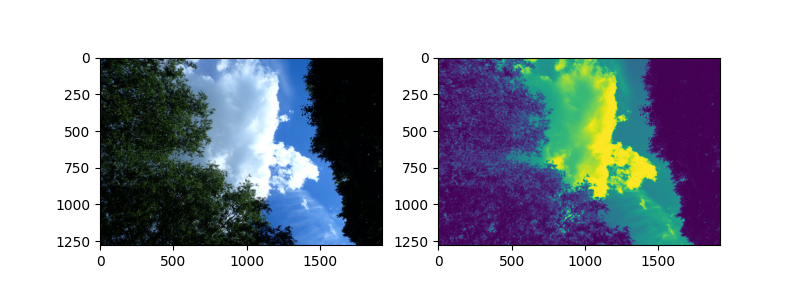

In [9]:
"""test"""
CANOPY_IMAGE = iio.imread(
    uri="../data/raw/2019-06/P6200003.JPG"
    )

CANOPY_IMAGE_IN_GRAYSCALE = skimage.color.rgb2gray(CANOPY_IMAGE)

fig, axes = pyplot.subplots(1, 2, figsize=(8, 3))  # Adjust DPI if needed
axes[0].imshow(CANOPY_IMAGE)
axes[0].axis('on')

axes[1].imshow(CANOPY_IMAGE_IN_GRAYSCALE)
axes[1].axis('on')

pyplot.show()

In [10]:
histogram, bin_edges = numpy.histogram(canopy_image_in_grayscale, bins=256, range=(0, 1))